In [1]:
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np #downgrade to V1.18.5
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, \
    LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import tensorflow as tf
import datetime
import h5py # saves np arrays

#CPU Only
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%load_ext tensorboard

In [2]:
# load datasets back into arrays
#dataset_1 = h5py.File('./dataset_1_orig.hdf5', 'r')
#dataset_1 = h5py.File('./dataset_1_scaled_255.hdf5', 'r')
dataset_1 = h5py.File('./dataset_1_grey.hdf5', 'r')
X = dataset_1.get('X')
X = np.array(X)
y = dataset_1.get('y')
y = np.array(y)
print(X.shape)
print(y.shape)
dataset_1.close()

(476, 480, 640, 1)
(476, 2)


In [3]:
#splits dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(357, 480, 640, 1)
(119, 480, 640, 1)
(357, 2)
(119, 2)


In [4]:
# model_1
ip = Input(shape=X_train[0].shape)
m = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(2, 2))(m)
m = Dropout(0.25)(m)
#m = Dropout(0.3)(m)
m = Flatten()(m)
m = Dense(64, activation='relu')(m)
op = Dense(2, activation='softmax')(m)
model = Model(ip, op)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 480, 640, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 240, 320, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 2457600)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                157286464 
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [4]:
# https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e
# model_2: from medium article with a few tweeks, worked well but is a pretty large nn for our applications
ip = Input(shape=X_train[0].shape)
m = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(ip)
m = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(m)
m = MaxPooling2D(pool_size=(2, 2))(m)
m = Dropout(0.25)(m)
m = Flatten()(m)
#m = Dense(32, activation='relu')(m)
m = Dense(64, activation='relu')(m)
#m = Dropout(0.5)(m)
m = Dropout(0.3)(m)
op = Dense(2, activation='softmax')(m)
model = Model(ip, op)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 480, 640, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 480, 640, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 240, 320, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 4915200)           0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [ ]:
# compiling/training model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train,
          y_train,
          epochs=30,
          batch_size=4,
          verbose=1,
          validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

model.save('./models/model_2a_grey.h5')

# model_1a_orig.h5 <-- 68.18% (opt=adam, learning_rate=0.0001, epochs=30, batch_size=4)
# model_1a_scaled_255.h5 <-- 62.18% (opt=adam, learning_rate=0.0001, epochs=30, batch_size=4)
# model_1a_grey.h5 <-- 66.39% (opt=adam, learning_rate=0.0001, epochs=30, batch_size=4)

Epoch 1/30
 1/90 [..............................] - ETA: 0s - loss: 2.4600 - accuracy: 0.5000WARNING:tensorflow:From C:\Users\hartw\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
90/90 [==============================] - 30s 337ms/step - loss: 250.4651 - accuracy: 0.5434 - val_loss: 3.7083 - val_accuracy: 0.5546
Epoch 2/30
90/90 [==============================] - 31s 346ms/step - loss: 1.1546 - accuracy: 0.6050 - val_loss: 0.6372 - val_accuracy: 0.5294
Epoch 3/30
90/90 [==============================] - 31s 344ms/step - loss: 0.6670 - accuracy: 0.6106 - val_loss: 0.6188 - val_accuracy: 0.5294
Epoch 4/30
90/90 [==============================] - 44s 492ms/step - loss: 1.6356 - accuracy: 0.5994 - val_loss: 0.6340 - val_accuracy: 0.5294
Epoch 5/30
89/90 [============================>.] - ET

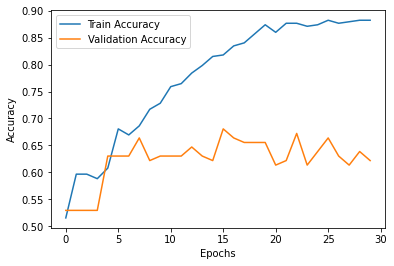

In [6]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('model_plots/model_2a_grey_accuracy')

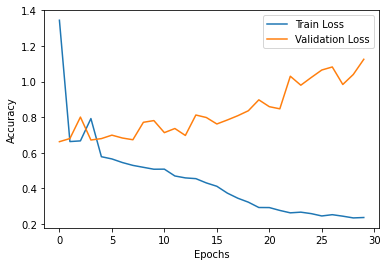

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('model_plots/model_2a_grey_loss')